In [2]:
import geopandas as gpd
import numpy as np
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from ipyleaflet import Map, GeoJSON, LayersControl, basemaps, Popup
from ipywidgets import Layout, VBox, HBox
import ipywidgets as widgets

def create_gradient_legend(cmap, min_val, max_val):
    """Generates an HTML legend for the colormap with a label."""
    rgb_values = [mpl.colors.rgb2hex(cmap(i)) for i in np.linspace(0, 1, 256)]
    gradient_style = ", ".join(rgb_values)
    legend_html = f"""
    <div style="text-align: center; font-weight: bold;">Area Difference (%)</div>
    <div style="display: flex; flex-direction: column; align-items: center;">
        <div style="
            background: linear-gradient(to right, {gradient_style});
            height: 30px;
            width: 200px;
            border: 1px solid black;
        "></div>
        <div style="text-align: center; width: 100%;">
            <span>Low: {min_val:.1f}%</span> | <span>High: {max_val:.1f}%</span>
        </div>
    </div>
    """
    return widgets.HTML(legend_html)

# Read GeoJSON files
gdf_line = gpd.read_file("~/freelance/02_ort_ecmwf/dev/hat/hat/mapping/station2grid_line.geojson")
gdf_line_new = gpd.read_file("~/freelance/02_ort_ecmwf/dev/hat/hat/mapping/station2grid_new_line.geojson")
gdf_station = gpd.read_file("~/freelance/02_ort_ecmwf/dev/hat/hat/mapping/station.geojson")
gdf_grid = gpd.read_file("~/freelance/02_ort_ecmwf/dev/hat/hat/mapping/original_grid_point.geojson")
gdf_grid_new = gpd.read_file("~/freelance/02_ort_ecmwf/dev/hat/hat/mapping/new_grid_point.geojson")

# Define a colormap (using Matplotlib)
cmap = plt.cm.get_cmap('PRGn')

# Normalize the "area_difference" column for the color mapping
min_val = - 1
max_val = 1
# min_val = gdf_line['area_difference'].min()
# max_val = gdf_line['area_difference'].max()
norm = plt.Normalize(vmin=min_val, vmax=max_val)
legend_widget = create_gradient_legend(cmap, min_val, max_val)


# Function to generate a click handler based on specific attributes
def make_line_click_handler(area_attr, distance_attr, map_object):
    def line_click_handler(feature, **kwargs):
        area_diff = feature['properties'].get(area_attr, 'N/A')
        distance_km = feature['properties'].get(distance_attr, 'N/A')

        # Format the popup message
        message_html = f"""
        <div>Area Difference (%): {area_diff:.1f}</div>
        <div>Distance (km): {distance_km:.1f}</div>
        """
        message = widgets.HTML(message_html)

        # Extract latitude and longitude for the popup
        coords = feature['geometry']['coordinates'][0]
        latlng = (coords[1], coords[0])  # Convert to (lat, lon) format
        popup = Popup(location=latlng, child=message, close_button=True, auto_close=True, close_on_escape_key=True)
        map_object.add_layer(popup)

    return line_click_handler


def make_style_callback(attribute):
    def style_callback(feature):
        """Style function for the GeoJSON layer based on a given attribute."""
        area_diff = feature['properties'][attribute]
        color = mcolors.to_hex(cmap(norm(area_diff))) if area_diff is not None else "#ffffff"
        return {'color': color, 'weight': 4}
    return style_callback

# Style for station points
station_style = {
    'radius': 5,
    'color': 'red',
    'fillColor': 'red',
    'fillOpacity': 1
}

# Style for grid points
grid_style = {
    'radius': 5,
    'color': 'blue',
    'fillColor': 'blue',
    'fillOpacity': 0
}

# Style for grid points
new_grid_style = {
    'radius': 5,
    'color': 'green',
    'fillColor': 'green',
    'fillOpacity': 0
}

DriverError: /home/dadiyorto/freelance/02_ort_ecmwf/dev/hat/hat/mapping/grid_point.geojson: No such file or directory

In [ ]:
# Create a Map instance
m = Map(basemap=basemaps.CartoDB.Positron,center=(0, 0), zoom=2, layout=Layout(height='600px'))

# Add GeoJSON layer for stations
geojson_station = GeoJSON(
    data=gdf_station.__geo_interface__, 
    point_style=station_style, 
    name="Stations"
)
m.add_layer(geojson_station)

# Add GeoJSON layer for grid
geojson_grid = GeoJSON(
    data=gdf_grid.__geo_interface__, 
    point_style=grid_style, 
    name="Grid Points"
)
m.add_layer(geojson_grid)

# Add GeoJSON layer for grid
geojson_grid_new = GeoJSON(
    data=gdf_grid_new.__geo_interface__, 
    point_style=new_grid_style, 
    name="New Grid Points"
)
m.add_layer(geojson_grid_new)

# Add styled GeoJSON layer for original lines
geojson_line = GeoJSON(
    data=gdf_line.__geo_interface__, 
    style_callback=make_style_callback('original_area_diff'), 
    name="Area Difference"
)
m.add_layer(geojson_line)
geojson_line.on_click(make_line_click_handler('original_area_diff', 'distance_km', m))

# Add styled GeoJSON layer for new lines
geojson_line_new = GeoJSON(
    data=gdf_line_new.__geo_interface__, 
    style_callback=make_style_callback('new_area_diff'), 
    name="New Area Difference"
)
m.add_layer(geojson_line_new)
geojson_line_new.on_click(make_line_click_handler('new_area_diff', 'new_distance_km', m))


# Add layers control
m.add_control(LayersControl())

# Display the map and legend in a vertical layout
display(widgets.VBox([m, legend_widget]))

<Axes: ylabel='Frequency'>

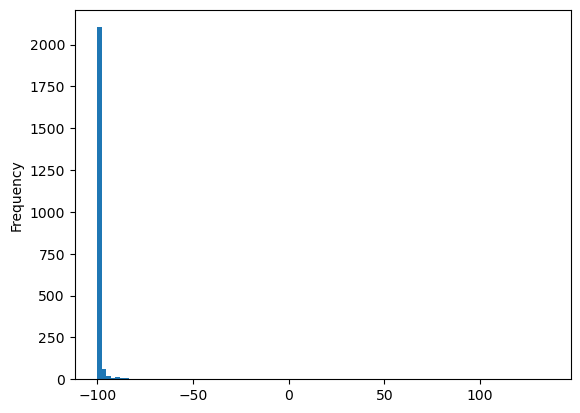

In [ ]:
gdf_line['new_area_diff'].plot.hist(bins=100)

In [ ]:
gdf_line

,station_name,station_lat,station_lon,grid_lat,grid_lon,nc_variable,csv_variable,original_area_diff,distance_km,new_grid_lat,new_grid_lon,new_nc_variable,new_area_diff,new_distance_km,geometry
0,Stolb,72.370000,126.800000,72.375000,126.808333,1.044240e+06,2460000.0,135.577972,0.625069,72.375000,126.808333,1.044240e+06,135.577972,0.625069,"LINESTRING (126.80000 72.37000, 126.80833 72.3..."
1,7_5Km Ds Of Mouth Of River Pur,72.120000,123.220000,72.125000,123.225000,1.269531e+07,198000.0,-98.440369,0.583668,72.125000,123.225000,1.269531e+07,-98.440369,0.583668,"LINESTRING (123.22000 72.12000, 123.22500 72.1..."
2,Saskylakh,71.980000,114.057000,71.975000,114.058333,7.849696e+10,78800.0,-99.999900,0.559828,71.975000,114.058333,7.849696e+10,-99.999900,0.559828,"LINESTRING (114.05700 71.98000, 114.05833 71.9..."
3,Khatanga,71.980000,102.450000,71.975000,102.458333,2.135056e+06,275000.0,-87.119776,0.627823,71.975000,102.458333,2.135056e+06,-87.119776,0.627823,"LINESTRING (102.45000 71.98000, 102.45833 71.9..."
4,Ubileynaya,70.750000,136.080000,70.758333,136.075000,2.233262e+11,224000.0,-99.999900,0.947797,70.758333,136.075000,2.233262e+11,-99.999900,0.947797,"LINESTRING (136.08000 70.75000, 136.07500 70.7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2237,Angostura,3.442589,-75.118703,3.441667,-75.125000,2.233444e+10,21788.0,-99.999902,0.707117,3.441667,-75.125000,2.233444e+10,-99.999902,0.707117,"LINESTRING (-75.11870 3.44259, -75.12500 3.44167)"
2238,Puente Santander,2.942861,-75.308663,2.941667,-75.308333,1.521313e+10,14897.0,-99.999902,0.137057,2.941667,-75.308333,1.521313e+10,-99.999902,0.137057,"LINESTRING (-75.30866 2.94286, -75.30833 2.94167)"
2239,Paso Del Colegio,2.462211,-75.566538,2.458333,-75.558333,1.192734e+10,11728.0,-99.999902,1.008222,2.458333,-75.558333,1.192734e+10,-99.999902,1.008222,"LINESTRING (-75.56654 2.46221, -75.55833 2.45833)"
2240,Pte Balseadero,2.232254,-75.651275,2.225000,-75.658333,5.556467e+09,5408.0,-99.999903,1.122425,2.225000,-75.658333,5.556467e+09,-99.999903,1.122425,"LINESTRING (-75.65127 2.23225, -75.65833 2.22500)"
